<a href="https://colab.research.google.com/github/benihime91/Covid-Waste-Detection/blob/main/IceVision-model-training-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Covid 19 Waste Detection

To train we will use the [IceVision](https://github.com/airctic/icevision) Library.

<img src="https://github.com/airctic/icevision/blob/master/images/icevision-logo-slogan.png?raw=true" width="500">


This notebook builds upon this [tutorial](https://github.com/airctic/icevision/blob/master/notebooks/wandb_efficientdet.ipynb).


# Installing IceVision, IceData

In [2]:
!pip install -Uqq git+git://github.com/airctic/icevision.git#egg=icevision[all]
!pip install -Uqq git+git://github.com/airctic/icedata.git
!pip install -Uqq PyYAML==5.4.1

     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 3.0MB 54.1MB/s 
     |████████████████████████████████| 194kB 55.0MB/s 
     |████████████████████████████████| 808kB 46.2MB/s 
     |████████████████████████████████| 112kB 59.1MB/s 
     |████████████████████████████████| 1.8MB 53.6MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 952kB 55.2MB/s 
     |████████████████████████████████| 38.2MB 80kB/s 
     |████████████████████████████████| 829kB 55.0MB/s 
     |████████████████████████████████| 112kB 57.6MB/s 
     |████████████████████████████████| 276kB 57.4MB/s 
     |████████████████████████████████| 296kB 54.7MB/s 
     |████████████████████████████████| 133kB 57.0MB/s 
    

In [3]:
# Needs to restart runtime in Google Colab
# What GPU are we using?
!nvidia-smi

Sun May  9 14:32:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [1]:
import icedata
from icevision.all import *
import torch
from torch import nn, optim

# Loading the Dataset

In [2]:
!unzip /content/drive/MyDrive/pascal-voc-waste-covid-19.zip -d /content/ > /dev/null

In [3]:
data_dir = Path("/content/pascal-voc-waste-covid-19/")

In [4]:
parser = parsers.VOCBBoxParser(data_dir/"train", data_dir/"train")
train_records, *_ = parser.parse(SingleSplitSplitter())

valid_parser =  parsers.VOCBBoxParser(data_dir/"test", data_dir/"test")
valid_records , *_ = valid_parser.parse(SingleSplitSplitter())

  0%|          | 0/189 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/189 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 64) - Clipping bbox xmax from 1025 to image width 1024 (Before: <BBox (xmin:683, ymin:716, xmax:1025, ymax:950)>) | icevision.utils.logger_utils:autofix_log:17


  0%|          | 0/80 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/80 [00:00<?, ?it/s]

Let's check out the class map for our Dataset to ensure that all the classes are properly registerd -

In [5]:
parser.class_map, valid_parser.class_map

(<ClassMap: {'background': 0, 'syringe': 1, 'glove': 2, 'mask': 3}>,
 <ClassMap: {'background': 0, 'syringe': 1, 'glove': 2, 'mask': 3}>)

## Train and Validation Datasets

In [6]:
presize = 900
size = 512

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

len(train_ds), len(valid_ds)

(189, 80)

## Create the model
In IceVision, we need to select the model type and backbone. For this tutorial, we are selecting efficientdet and the `efficientdet-b3` backbone. Some models require additional information, such as the `image_size`.

In [7]:
# Library and model selection
model_type = models.ross.efficientdet
backbone = model_type.backbones.d0(pretrained=True)

# The efficientdet model requires an img_size parameter
extra_args = {'img_size' : size}

model = efficientdet.model(backbone=backbone, num_classes=len(parser.class_map), **extra_args)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/efficientdet_d0-f3276ba8.pth" to /root/.cache/torch/hub/checkpoints/efficientdet_d0-f3276ba8.pth


## Create the dataloaders

In [8]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=8, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, shuffle=False)

Showing what's inside a batch

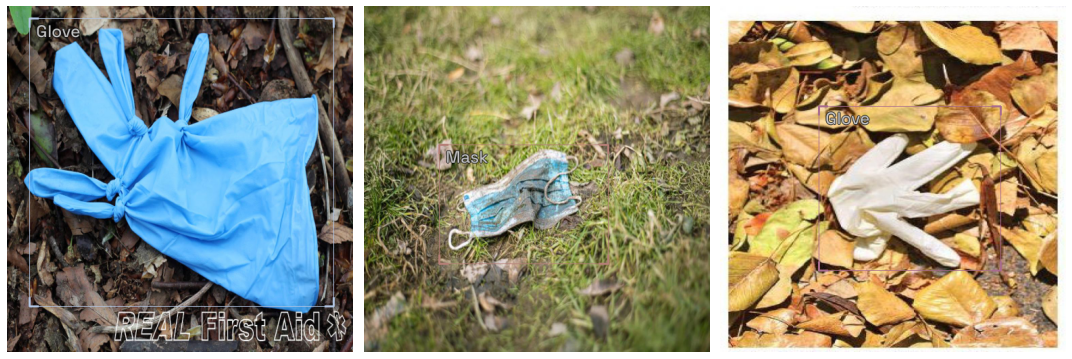

In [11]:
dl = model_type.valid_dl(valid_ds, batch_size=3, shuffle=True)
batch = first(dl)
model_type.show_batch(batch, ncols=3, figsize=(15,15))

# Training

In [12]:
class LitModel(model_type.lightning.ModelAdapter):
    
    def configure_optimizers(self):
        opt = optim.SGD(self.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
        sched = optim.lr_scheduler.StepLR(opt, step_size=10, verbose=True)
        return [opt], [sched]

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [14]:
learn = LitModel(model, metrics=metrics)

cbs = [
    pl.callbacks.ModelCheckpoint(dirpath="/content/outputs/", verbose=1, save_weights_only=True, monitor="valid/loss"),
]
log = [
    pl.loggers.CSVLogger(save_dir="/content/outputs/", name="efficientdet-d0"),
    pl.loggers.TensorBoardLogger(save_dir="/content/lightning_logs/", default_hp_metric=False, name="efficientdet-d0")
]

trainer = pl.Trainer(max_epochs=40, gpus=-1, precision=16, callbacks=cbs, logger=log, log_every_n_steps=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [15]:
trainer.fit(learn, train_dl, valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs/efficientdet-d0

  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 3.8 M 
----------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.307    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 5.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 23: valid/loss reached 1.45439 (best 1.45439), saving model to "/content/outputs/epoch=0-step=23.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 47: valid/loss reached 1.41000 (best 1.41000), saving model to "/content/outputs/epoch=1-step=47.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 71: valid/loss reached 1.30051 (best 1.30051), saving model to "/content/outputs/epoch=2-step=71.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 95: valid/loss reached 1.17107 (best 1.17107), saving model to "/content/outputs/epoch=3-step=95.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 119: valid/loss reached 1.00595 (best 1.00595), saving model to "/content/outputs/epoch=4-step=119.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 143: valid/loss reached 0.91329 (best 0.91329), saving model to "/content/outputs/epoch=5-step=143.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 167: valid/loss reached 0.88109 (best 0.88109), saving model to "/content/outputs/epoch=6-step=167.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 191: valid/loss reached 0.85093 (best 0.85093), saving model to "/content/outputs/epoch=7-step=191.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 215: valid/loss reached 0.79206 (best 0.79206), saving model to "/content/outputs/epoch=8-step=215.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 239: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 263: valid/loss reached 0.78192 (best 0.78192), saving model to "/content/outputs/epoch=10-step=263.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 287: valid/loss reached 0.76267 (best 0.76267), saving model to "/content/outputs/epoch=11-step=287.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 311: valid/loss reached 0.76041 (best 0.76041), saving model to "/content/outputs/epoch=12-step=311.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 335: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 359: valid/loss reached 0.74590 (best 0.74590), saving model to "/content/outputs/epoch=14-step=359.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 383: valid/loss reached 0.74539 (best 0.74539), saving model to "/content/outputs/epoch=15-step=383.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 407: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 431: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 455: valid/loss reached 0.74430 (best 0.74430), saving model to "/content/outputs/epoch=18-step=455.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-04.


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 479: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 503: valid/loss reached 0.74268 (best 0.74268), saving model to "/content/outputs/epoch=20-step=503.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 527: valid/loss reached 0.74191 (best 0.74191), saving model to "/content/outputs/epoch=21-step=527.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 551: valid/loss reached 0.73864 (best 0.73864), saving model to "/content/outputs/epoch=22-step=551.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 575: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 599: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 623: valid/loss reached 0.73856 (best 0.73856), saving model to "/content/outputs/epoch=25-step=623.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 647: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 671: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 695: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 719: valid/loss reached 0.73654 (best 0.73654), saving model to "/content/outputs/epoch=29-step=719.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 743: valid/loss reached 0.73318 (best 0.73318), saving model to "/content/outputs/epoch=30-step=743.ckpt" as top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 767: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 791: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 815: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 839: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 863: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 887: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 911: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 935: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 959: valid/loss was not in top 1


Adjusting learning rate of group 0 to 5.0000e-07.


In [26]:
results = trainer.validate(verbose=False)
results

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'COCOMetric/AP (IoU=0.50) area=all': 0.6896549031483064,
  'COCOMetric/AP (IoU=0.50:0.95) area=all': 0.3186388071856282,
  'COCOMetric/AP (IoU=0.50:0.95) area=large': 0.33758259951618586,
  'COCOMetric/AP (IoU=0.50:0.95) area=medium': 0.15309004502934762,
  'COCOMetric/AP (IoU=0.50:0.95) area=small': -1.0,
  'COCOMetric/AP (IoU=0.75) area=all': 0.2428880441805794,
  'COCOMetric/AR (IoU=0.50:0.95) area=all maxDets=1': 0.34593318809005086,
  'COCOMetric/AR (IoU=0.50:0.95) area=all maxDets=10': 0.4849346405228758,
  'COCOMetric/AR (IoU=0.50:0.95) area=all maxDets=100': 0.5120297748729121,
  'COCOMetric/AR (IoU=0.50:0.95) area=large maxDets=100': 0.5228828045777199,
  'COCOMetric/AR (IoU=0.50:0.95) area=medium maxDets=100': 0.3416666666666667,
  'COCOMetric/AR (IoU=0.50:0.95) area=small maxDets=100': -1.0,
  'valid/box_loss': 0.004374225623905659,
  'valid/class_loss': 0.5144659280776978,
  'valid/loss': 0.7331771850585938}]

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "/content/lightning_logs/"

In [ ]:
!tensorboard dev upload --logdir "lightning_logs/efficientdet-d0/" \
    --name "Covid Waste Detection Ice Vision" \
    --description "Efficientdet-0 Model Training"
    --one_shot

[Link](https://tensorboard.dev/experiment/zL5tpC5OSJKMLMrKmwaDgA/)

# Showing training results

In [31]:
# model_type.show_results(model, valid_ds, detection_threshold=0.45, num_samples=3, ncols=4)

# Inference pipeline

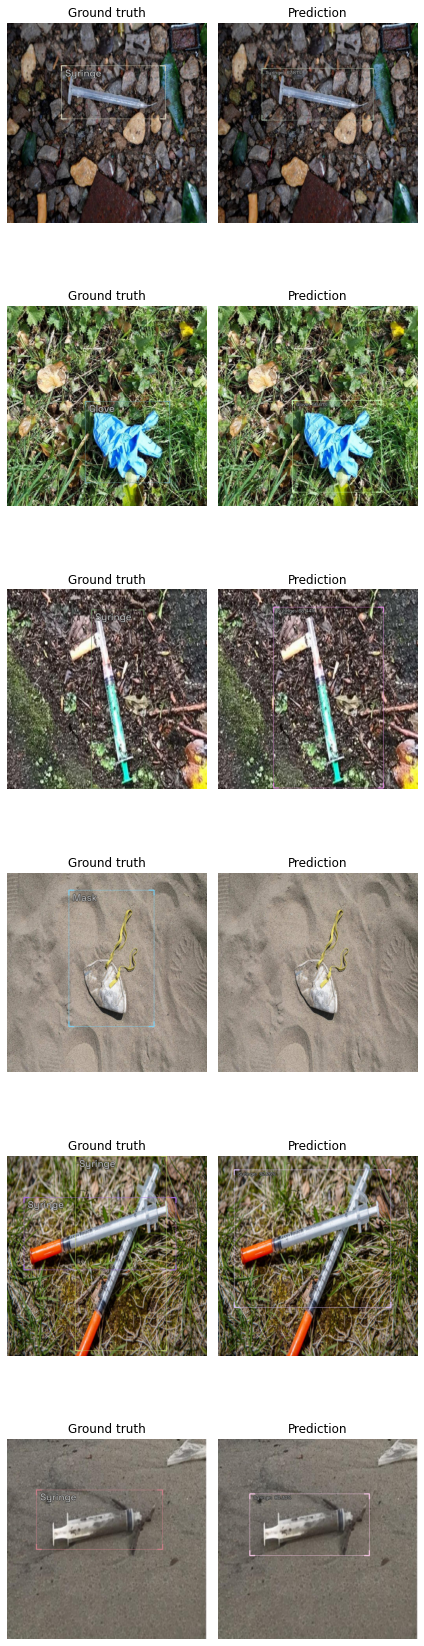

In [34]:
preds = model_type.predict(model, valid_ds, detection_threshold=0.45)

show_preds(preds=preds[:6], denormalize_fn=denormalize_imagenet, ncols=3)

  0%|          | 0/80 [00:00<?, ?it/s]

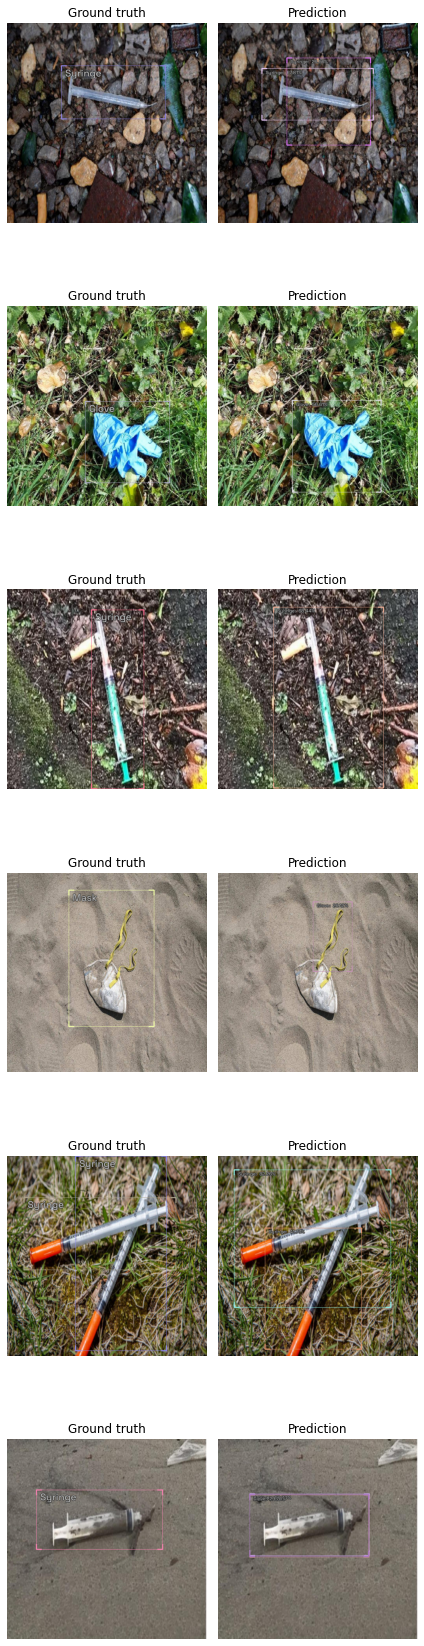

In [35]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=1, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, detection_threshold=0.25, keep_images=True)
show_preds(preds=preds[:6], denormalize_fn=denormalize_imagenet, ncols=3,)

In [42]:
import shortuuid

idx = shortuuid.uuid()[:5]
path = f"drive/MyDrive/effecientdnet-b0-ver0.01-{idx}.pth"
torch.save(model.state_dict(), path)

In [46]:
assert model.load_state_dict(torch.load(path, map_location="cpu"), strict=True)